We got employee data from a few companies. We have data about all employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general info about the employee, such as average salary during her tenure, department, and years of experience. As said above, the goal is to predict employee retention and understand its main drivers

What are the main factors that drive employee churn? Do they make sense? Explain your findings.
What might you be able to do for the company to address employee Churn, what would be follow-up actions?
If you could add to this data set just one variable that could help explain employee churn, what would that be?
Your output should be in the form a a jupyter notebook and pdf output of a jupyter notebook in which you specify your results and how you got them.

Data

The table is:
"employee_retention" - comprehensive information about employees. Columns:
employee_id : id of the employee. Unique by employee per company
company_id : company id.
dept : employee department
seniority : number of yrs of work experience when hired
salary: average yearly salary of the employee during her tenure within the company
join_date: when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13
quit_date: when the employee left her job (if she is still employed as of 2015/12/13, this field is NA)

In [247]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt

df = pd.read_csv('../employee_retention.csv', index_col = 0)

In [248]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,1001444.0,8,temp_contractor,0,5850.0,2008-01-26,2008-04-25
1,388804.0,8,design,21,191000.0,05.17.2011,2012-03-16
2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10
3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30
4,1006393.0,1,temp_contractor,0,8509.0,2008-07-20,2008-10-18


The dates in join_date and quit_date are in all sorts of different formats, we'll need to clean them up and turn them into pandas datetime format.

In [249]:
df['join_date'] = pd.to_datetime(df['join_date'], errors = 'coerce')
df['quit_date'] = pd.to_datetime(df['quit_date'], errors = 'coerce')
df.head()
#df['date'] = df['join_date'].dt.date
#dates = df['date']

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,1001444.0,8,temp_contractor,0,5850.0,2008-01-26,2008-04-25
1,388804.0,8,design,21,191000.0,2011-05-17,2012-03-16
2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10
3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30
4,1006393.0,1,temp_contractor,0,8509.0,2008-07-20,2008-10-18


In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34702 entries, 0 to 34701
Data columns (total 7 columns):
employee_id    34702 non-null float64
company_id     34702 non-null int64
dept           34702 non-null object
seniority      34702 non-null int64
salary         34463 non-null float64
join_date      34702 non-null datetime64[ns]
quit_date      23510 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 2.1+ MB


In [251]:
df.isnull().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary           239
join_date          0
quit_date      11192
dtype: int64

It seems that we are missing salary information from 239 employees. Since the salary could be an important piece of information in figuring out reasons for employee churn, we could eliminate these observations (we have a total of 34702 employees, so it's less than 1% of the data. 

In [252]:
df1=df.dropna(subset=['salary'])

In [253]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34463 entries, 0 to 34701
Data columns (total 7 columns):
employee_id    34463 non-null float64
company_id     34463 non-null int64
dept           34463 non-null object
seniority      34463 non-null int64
salary         34463 non-null float64
join_date      34463 non-null datetime64[ns]
quit_date      23379 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 2.1+ MB


In [254]:
df1.isnull().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11084
dtype: int64

108 of the 239 employees with missing salary information are still employed, so the distribution of the subgroup is even between the interest labels (still employed or not). This means we can safely eliminate those from the dateset. Furthermore, let's look closer at the temp contractors, and see if there is any interesting info there.

In [255]:
df = df1
df_temp_contr = df[df['dept']=='temp_contractor']
df_temp_contr.head()
df_temp_contr['duration'] = df_temp_contr['quit_date']-df_temp_contr['join_date']

/Users/oana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [256]:
df_temp_contr.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,duration
0,1001444.0,8,temp_contractor,0,5850.0,2008-01-26,2008-04-25,90 days
4,1006393.0,1,temp_contractor,0,8509.0,2008-07-20,2008-10-18,90 days
17,1007464.0,7,temp_contractor,0,7748.0,2009-11-14,2010-02-12,90 days
18,1002775.0,3,temp_contractor,0,7424.0,2008-01-14,2008-04-13,90 days
20,1000103.0,5,temp_contractor,0,9684.0,2008-05-18,2008-08-16,90 days


It seems they are hired at least often for just a 90 day period (90 day contracts). Is this common? 

In [257]:
np.max(df_temp_contr['duration'])

Timedelta('90 days 00:00:00')

In [258]:
np.min(df_temp_contr['duration'])

Timedelta('90 days 00:00:00')

Looks like most of the employees are temporary contractors (makes sense), but what are their salaries like, and are there big disparities between companies for the same jobs?

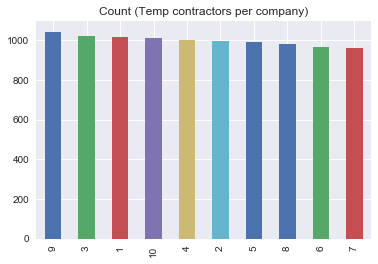

In [259]:
df_temp_contr['company_id'].value_counts().plot(kind='bar', title='Count (Temp contractors per company)');

Although the temp contractor salaries vary a little bit (not much), they always work for 90 days only, and they are fairly equally distributed between our companies. Since it's clear that their data won't offer any information on reasons for employee churn whatsoever, let's just eliminate it from the data. 

In [260]:
df = df[df['dept']!='temp_contractor']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24463 entries, 1 to 34701
Data columns (total 7 columns):
employee_id    24463 non-null float64
company_id     24463 non-null int64
dept           24463 non-null object
seniority      24463 non-null int64
salary         24463 non-null float64
join_date      24463 non-null datetime64[ns]
quit_date      13379 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 1.5+ MB


Let's also add a column for the duration of employment (just a deltatime)

In [261]:
df['duration'] = df['quit_date']-df['join_date']
df.head()

/Users/oana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,duration
1,388804.0,8,design,21,191000.0,2011-05-17,2012-03-16,304 days
2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10,1110 days
3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30,662 days
5,287530.0,5,marketing,20,180000.0,2014-06-30,NaT,NaT
6,561043.0,3,customer_service,18,119000.0,2012-07-02,2014-03-28,634 days


### Let's make some visual EDA for what we have

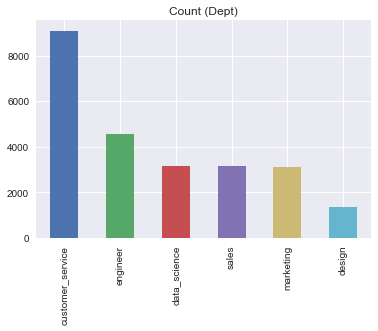

In [262]:
sns.set()
df['dept'].value_counts().plot(kind='bar', title='Count (Dept)');

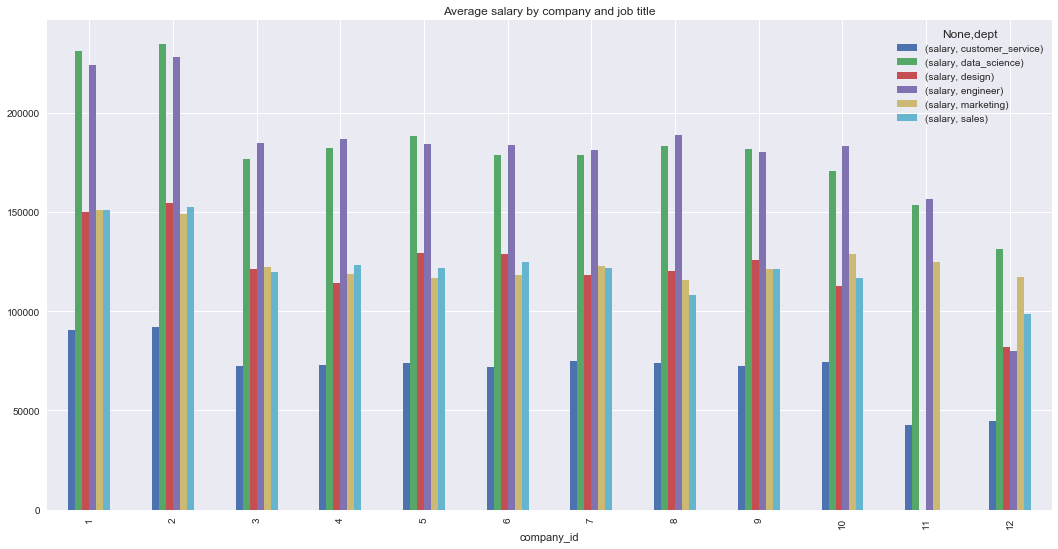

In [263]:
df.groupby([ 'company_id','dept']).agg({'salary':np.mean}).unstack().plot(kind = 'bar',figsize=(18,9));
_=plt.title('Average salary by company and job title')

There is a general pattern clear here: company 1 and company 2 are paying their employees a little higher wages overall, for all categories. Every company pays temp workers the exact same salary. Engineers and data scietist are the highest paid employees overall (except company 12, which pays engineers lower salaries than most other employees). Company 11 does not employ designers, and companies 11 and 12 do not employ sales people or temporary contractors.

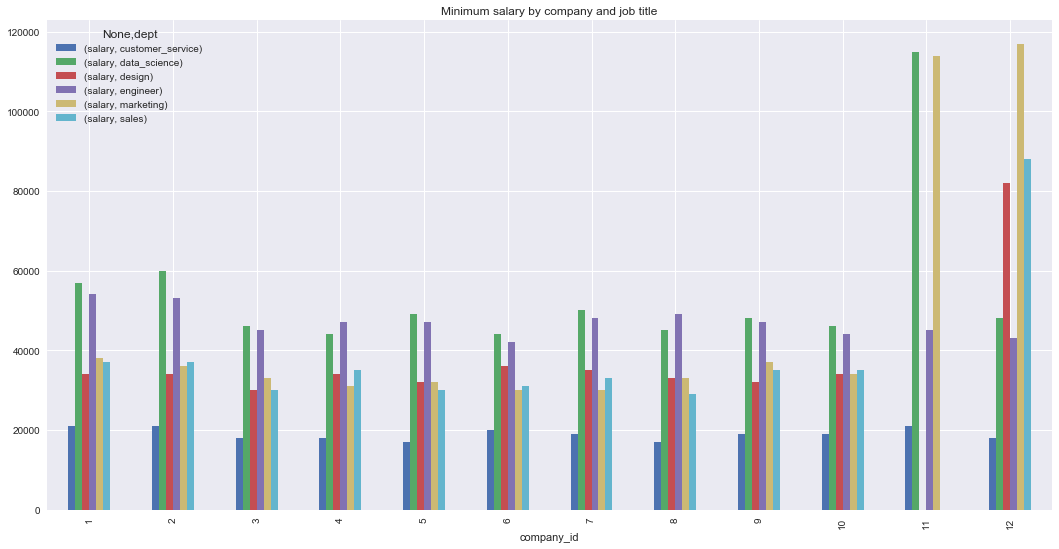

In [264]:
df.groupby([ 'company_id','dept']).agg({'salary':np.min}).unstack().plot(kind = 'bar',figsize=(18,9));
_=plt.title('Minimum salary by company and job title')

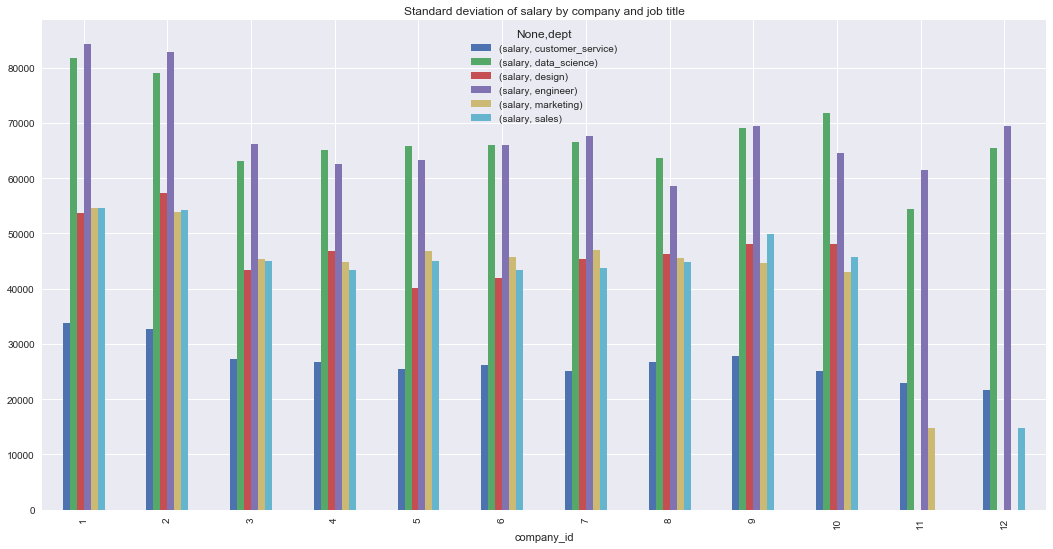

In [265]:
df.groupby([ 'company_id','dept']).agg({'salary':np.std}).unstack().plot(kind = 'bar',figsize=(18,9));
_=plt.title('Standard deviation of salary by company and job title')

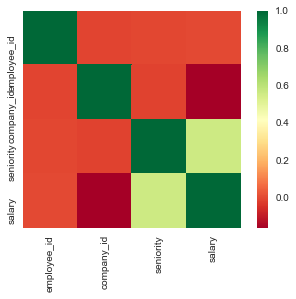

In [266]:
_ = sns.heatmap(df.corr(), square=True, cmap = 'RdYlGn')

Looks like there is a some correlation between seniority and salary. In order to look closer at the influence of senioriy, salary, company (culture), and dept on time at the company (and implicitly on churn), let's figure out how these features influence the likeihood of employees leaving.

In [267]:
df_new = pd.get_dummies(df)
df_new['churned'] = 1
#df_new[df_new.duration.isnull()]
df_new['churned'][df_new.duration.isnull()] = 0
df_new.head()

/Users/oana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,employee_id,company_id,seniority,salary,join_date,quit_date,duration,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales,churned
1,388804.0,8,21,191000.0,2011-05-17,2012-03-16,304 days,0,0,1,0,0,0,1
2,407990.0,3,9,90000.0,2012-03-26,2015-04-10,1110 days,0,0,1,0,0,0,1
3,120657.0,2,20,298000.0,2013-04-08,2015-01-30,662 days,0,0,0,1,0,0,1
5,287530.0,5,20,180000.0,2014-06-30,NaT,NaT,0,0,0,0,1,0,0
6,561043.0,3,18,119000.0,2012-07-02,2014-03-28,634 days,1,0,0,0,0,0,1


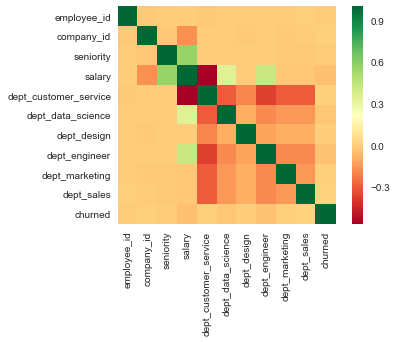

In [268]:
_ = sns.heatmap(df_new.corr(), square=True, cmap = 'RdYlGn')

No handles with labels found to put in legend.


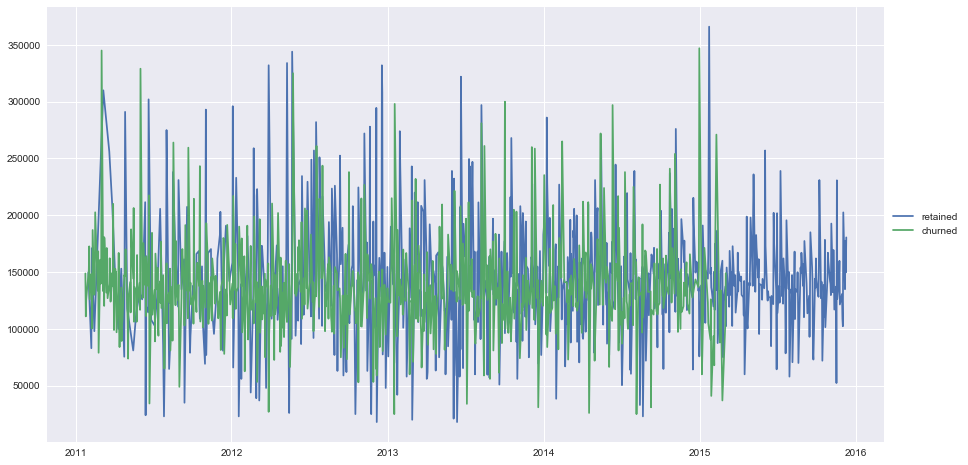

In [269]:
df1 = df_new[df_new['churned']== 1][['salary','join_date']]
grp_mean=df1.groupby('join_date').mean()
#print(grp_mean)
df2 = df_new[df_new['churned']== 0][['salary','join_date']]
grp_mean2=df2.groupby('join_date').mean()

figure = plt.figure(figsize=(15, 8))
_=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
_=plt.plot(grp_mean2['salary'],'-', label="retained")

_=plt.plot(grp_mean['salary'],'-', label="churned")
_=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

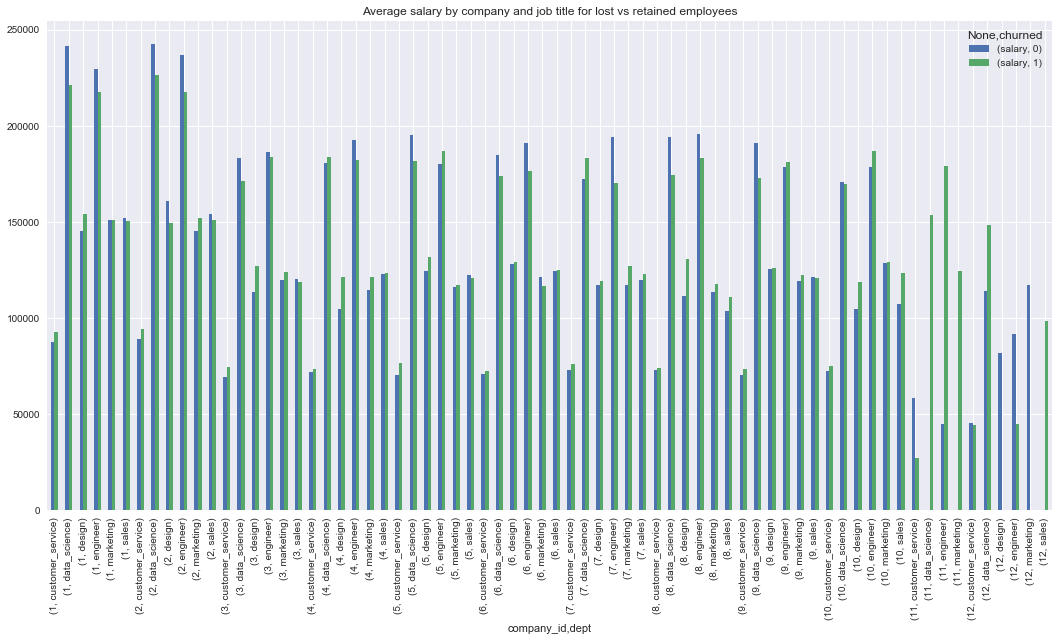

In [270]:
df['churned'] = df_new['churned']
df.groupby([ 'company_id','dept','churned']).agg({'salary':np.mean}).unstack().plot(kind = 'bar',figsize=(18,9));
_=plt.title('Average salary by company and job title for lost vs retained employees')

This shows that generally the average salary of people who leave are lower than those of people who stay, but also - interestingly - there is something about company 11 that makes them lose a lot of employees (all their data scientists and marketing people are lost, and they lost engineers that were better paid than the ones they still have, so maybe there is something else driving people away there)

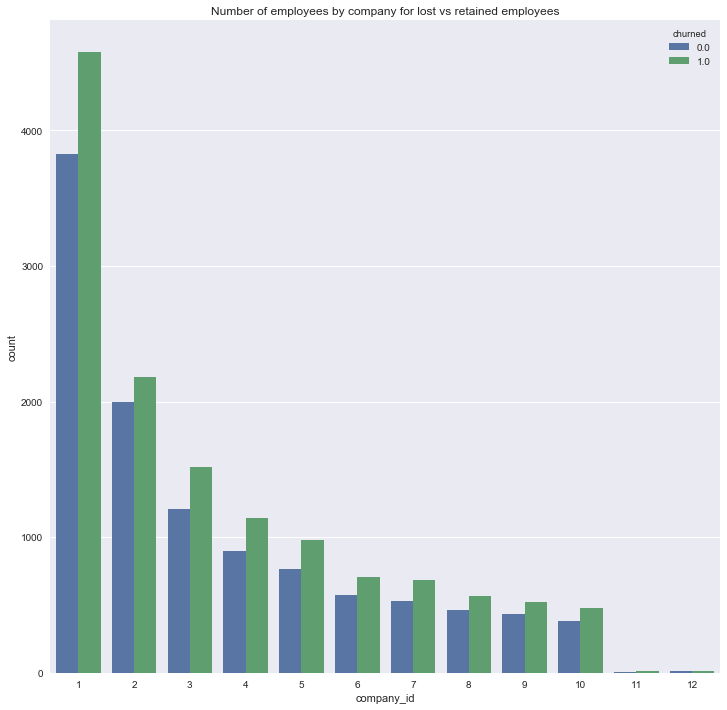

In [209]:
plt.figure(figsize=(12,12))
sns.countplot(x='company_id',data=df, hue='churned')
_=plt.title('Number of employees by company for lost vs retained employees')

Looking at just number of employees by company highlights the fact that companies 11 and 12 are very small.

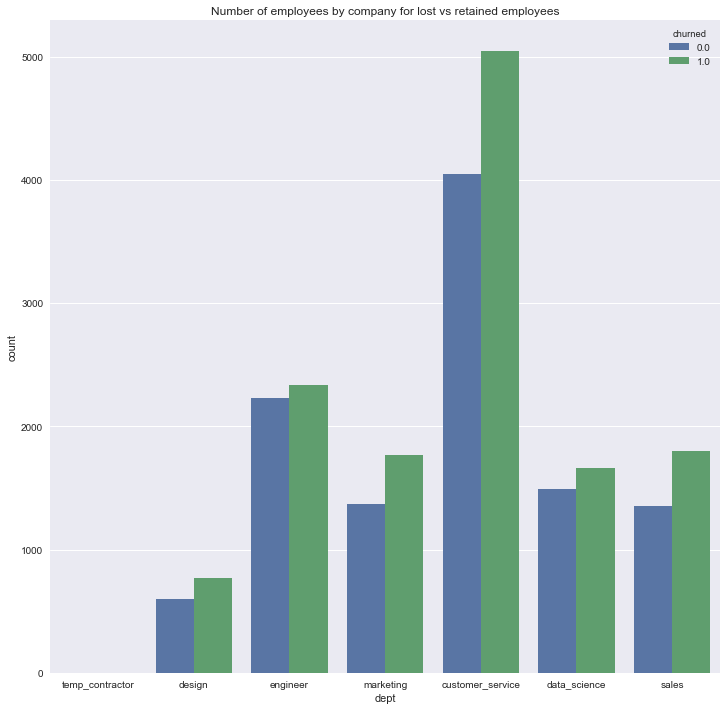

In [221]:
plt.figure(figsize=(12,12))

sns.countplot(x='dept',data=df, hue='churned')
_=plt.title('Number of employees by company for lost vs retained employees')

### If I had just one more feature for explaining employee churn, I would like to have promotion (salary increases over time at the company), although I'd really like to have a lot more features.

In [243]:
#Before moving on to the classifier (for prediction), let's turn the duration into 1825 days
end = pd.to_datetime('2016-01-24')
df_new['quit_date'] = df['quit_date'].fillna(end)
df_new['duration'] = df_new['quit_date']-df_new['join_date']
df_new['duration'] = df_new['duration'].dt.days
df_new.head()

,employee_id,company_id,seniority,salary,join_date,quit_date,duration,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales,churned
1,388804.0,8,21,191000.0,2011-05-17,2012-03-16,304,0,0,1,0,0,0,1
2,407990.0,3,9,90000.0,2012-03-26,2015-04-10,1110,0,0,1,0,0,0,1
3,120657.0,2,20,298000.0,2013-04-08,2015-01-30,662,0,0,0,1,0,0,1
5,287530.0,5,20,180000.0,2014-06-30,2016-01-24,573,0,0,0,0,1,0,0
6,561043.0,3,18,119000.0,2012-07-02,2014-03-28,634,1,0,0,0,0,0,1


In [244]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tools import categorical

X = df_new.drop(['churned','quit_date', 'join_date', 'employee_id'], axis = 1)
y = df_new['churned']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
X_train.shape


(19570, 10)

In [245]:
n_features = X_train.shape[1]
scaler = StandardScaler()
rfc = RandomForestClassifier(random_state=42,
                             n_estimators=500,
                             class_weight="balanced")
scaler.fit(X_train, y_train)
rfc.fit(X_train, y_train)

feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances

,importance
duration,0.551040
salary,0.225550
seniority,0.128242
company_id,0.072563
dept_marketing,0.004381
dept_sales,0.004077
dept_engineer,0.003870
dept_data_science,0.003638
dept_design,0.003609
dept_customer_service,0.003030


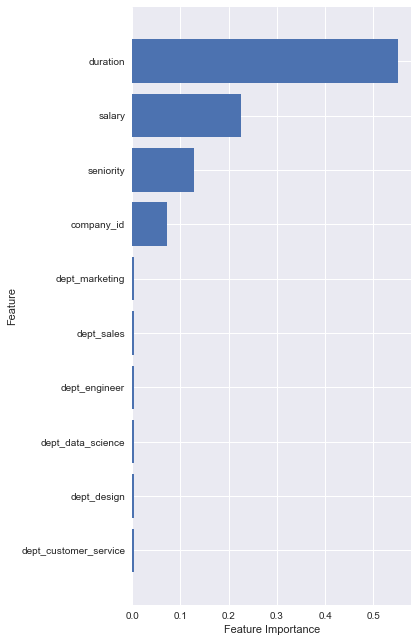

In [246]:
plt.figure(figsize=(5,11))
plt.barh(range(n_features), feature_importances['importance'], align = 'center')
plt.yticks(np.arange(n_features), list(feature_importances.index))
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features)
plt.gca().invert_yaxis()
plt.show()


Time spent with the company, salary, seniority and company_id are the most important feature in the given dataset that can predict employee churn. The dataset, however, could have a lot more data that could be important: employee gender, performance evaluation scores, merit based bonus, benefits (vacation days, overtime pay, sick leave, parental leave, health insurance, etc), work-life balance (how many hours per week the employee spends at the office).